In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tabulate

In [ ]:
!pip install cs50


In [ ]:
import json
import pickle
import os
import re
import csv
import time
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.models import load_model, model_from_json

from cs50 import SQL
from tabulate import tabulate

from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score,  confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from gensim.models import Word2Vec


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# read database

In [ ]:
db = SQL("sqlite:////content/drive/MyDrive/HK2_2023-2024/NT522/Dataset/bin_similar/bin_similar.db")

In [ ]:

# get filter function id have mother 30 instruction lines
df_function_id = pd.read_csv("/content/drive/MyDrive/HK2_2023-2024/NT522/Dataset/other_stuff/filter_function_id.csv")

In [ ]:
filterd_function_ids = list(df_function_id['function_id'].tolist())

In [ ]:
# algorithms to obtain dataset tabulat dataset
# we will focus on archirecture and
# function1 | function2 | label
# follwing describle: https://bedecked-beam-210.notion.site/Dataset-b8b4e490eb8c4fb0a126ea17f4cd6fe4?pvs=4

def get_function_ids(optimizer, complier,compiler_version,  binary_name, architecture):
  '''
  optimizer: string
  complier: string
  binary_name: string
  architecture: string
  return: list of function id

  '''
  rows = db.execute("SELECT id FROM function_name WHERE  id IN (SELECT function_id FROM binary_function_mapping WHERE binary_id = (SELECT id FROM binary_name WHERE binary_name = ? AND compiler = ? AND compiler_version = ?  AND architecture = ?)) ",  optimizer + "_" + binary_name , complier, compiler_version, architecture )
  return [row['id'] for row in rows]

def get_disassambly(function_id):
  disassambly_fuctions = []
  rows = db.execute("SELECT disassambly FROM function_disassambly WHERE function_id = ?", function_id)
  data = rows[0]['disassambly']
  try:
    dt = pickle.loads(bytes(data, 'latin-1'))
  except:
    print("can't load function id = ", function_id)
    pass
  else:
    disassambly_fuctions = dt
  return disassambly_fuctions


In [ ]:
def _get_common_functions_binary(binary_name):
  '''
  binary_name: string
  return: list of function name
  '''
  rows = db.execute("SELECT function_name FROM function_name WHERE id IN (SELECT function_id FROM binary_function_mapping WHERE binary_id = (SELECT id FROM binary_name WHERE binary_name LIKE ?))", "%" + binary_name )
  return [row['function_name'] for row in rows]

def get_id_function_name_binary(optimizer, complier,compiler_version,  binary_name, architecture, function_name ):
  '''
  optimizer: string
  complier: string
  binary_name: string
  architecture: string
  return: function id
  '''
  rows = db.execute("SELECT id FROM function_name WHERE id IN (SELECT function_id FROM binary_function_mapping WHERE binary_id = (SELECT id FROM binary_name WHERE binary_name = ? AND compiler = ? AND compiler_version = ? AND architecture = ? )) AND function_name = ?", optimizer + "_" + binary_name, complier, compiler_version, architecture, function_name )
  if len(rows) == 0:
    print("can't find function name = ", function_name)
    return None
  return rows[0]['id']

def get_function_name_by_id(function_id):
  ''' get function name by id function'''

  rows = db.execute("SELECT function_name FROM function_name WHERE id = ?", function_id)
  if len(rows) == 0:
    print("can't find function id = ", function_id)
    return None
  return rows[0]['function_name']

def get_list_id_function(binary_name, architecture, function_name):
  rows = db.execute("SELECT id FROM function_name WHERE id IN (SELECT function_id FROM binary_function_mapping WHERE binary_id IN (SELECT id FROM binary_name WHERE binary_name LIKE ?  AND architecture = ?)) AND function_name = ?", "%" + binary_name,architecture, function_name)
  if len(rows) == 0:
    print("can't find function name = ", function_name)
    return None
  return [row['id'] for row in rows]


In [ ]:
# "nmap":["ncat", "nmap", "nping"],
nmap_bin = ["ncat", "nmap", "nping"]
list_of_bin = {
     "clamav":["sigtool", "clambc", "clamconf", "clamscan", "freshclam", "libclamav.so.9.0.0"],

     "curl":["curl"],
     "nmap":["ncat", "nmap", "nping"],
     "openssl":["afalg.so", "capi.so", "dasync.so", "fips.so", "legacy.so", "libcrypto.so.3", "libssl.so.3","openssl", "ossltest.so", "padlock.so"],
     "unrar":["unrar"],
     "zlib":["libz.so.1.2.11", "minigzip", "minigzip64", "minigzipsh"]
}

common_functions = {}
for binary in list_of_bin.keys():
  common_functions[binary]= {}
  for function in list_of_bin[binary]:
    common_functions[binary][function] = _get_common_functions_binary(function)


In [ ]:
data = {}
for key in common_functions.keys():
  functions = []
  for value in common_functions[key].values():
    functions.extend(value)
  data[key] =








In [ ]:
#create index sql
try:
    db.execute("""
    CREATE INDEX IF NOT EXISTS idx_binary_name_name_architecture
    ON binary_name (binary_name, architecture);
    """)
    db.execute("""
    CREATE INDEX IF NOT EXISTS idx_binary_function_mapping_binary_id
    ON binary_function_mapping (binary_id);
    """)
    db.execute("""
    CREATE INDEX IF NOT EXISTS idx_binary_function_mapping_function_id
    ON binary_function_mapping (function_id);
    """)
except Exception as e:
    print(f"Error occurred: {e}")

In [ ]:
# positive pairs
# The same architecure
# Cross-optimization
# Cross-compiler





# get negative pairs

In [ ]:


data = {}
for key in common_functions.keys():
    data[key] = {}
    for subkey, values in common_functions[key].items():
        data[key][subkey] = {}
        for item in values:
          data[key][subkey][item] = get_list_id_function(binary_name=subkey, architecture='x86', function_name=item) + get_list_id_function(binary_name=subkey, architecture='x64', function_name=item)




In [ ]:
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/function_ids.pkl", "wb") as pikl_file:
  pickle.dump(data,pikl_file)

In [ ]:


with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/function_ids.pkl", "rb") as pikl_file:
    data = pickle.load(pikl_file)


In [ ]:
import sys
for top_key, nested_dict in data.items():
      for sub_key, list_dict in nested_dict.items():
          for list_key, list_values in list_dict.items():
              # Update the values in the list

            list_values_set = set(list_values)
            filtered_ids = list_values_set.intersection(filterd_function_ids)
            data[top_key][sub_key][list_key] = list(filtered_ids)

In [ ]:
dt_functions = data

In [ ]:
#negative pair functions

negative_pairs = []

while(len(negative_pairs) <= 27000):
  for item in dt_functions.keys():

    random_bin = random.choice([key for key in list(dt_functions.keys()) if key != item])
    subbin1 = random.choice(list(dt_functions[item].keys()))
    subbin2 = random.choice(list(dt_functions[random_bin].keys()))

    function1 = random.choice(list(dt_functions[item][subbin1].keys()))
    function2 = random.choice(list(dt_functions[random_bin][subbin2].keys()))

    if (function1 != function2) and (len(dt_functions[item][subbin1][function1]) > 0 and len(dt_functions[random_bin][subbin2][function2]) > 0):

      id_function1 = random.choice(dt_functions[item][subbin1][function1])
      id_function2 = random.choice(dt_functions[random_bin][subbin2][function2])
      if (id_function1, id_function2) not in negative_pairs:
        negative_pairs.append((id_function1, id_function2))











In [ ]:
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/positive_pair_function.csv", "r") as csv_file:
  reader = csv.reader(csv_file)
  positive_pairs = [row for row in reader]
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/cross_complier_ids_pairs.csv", "w", newline='') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['function1', 'function2', 'Class'])
  for item in positive_pairs:
    writer.writerow([item[0], item[1], 1])
  for item in negative_pairs:
    writer.writerow([item[0], item[1], 0])



In [ ]:
dftest = pd.read_csv("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/cross_complier_ids_pairs.csv")

In [ ]:
# Cross-compiler
# function pairs
#positive pairs
# Only the compilers are different



optimizer_list = [ "O0", "O1", "O2", "O3"]

positive_pairs_cross_compiler = []
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/positive_pair_function.csv", 'w', newline='') as csv_file:
  writer = csv.writer(csv_file)

  for bin in list_of_bin.keys():
    for bin_type in list_of_bin[bin]:
      for function in common_functions[bin_type]:
        for optimizer in optimizer_list:
          architetures = random.choice(['x64', 'x86'])


          id_function1 = get_id_function_name_binary(optimizer, "gcc", random.choice(["4.8", "5", "9", "7"]), bin_type, architetures, function)
          id_function2 = get_id_function_name_binary(optimizer, "clang", random.choice(["3.5", "5.0", "7", "9"]), bin_type, architetures, function)
          if id_function1 in filterd_function_ids and id_function2 in filterd_function_ids:
            positive_pairs_cross_compiler.append((id_function1, id_function2))
            writer.writerow([id_function1, id_function2])

            if len(positive_pairs_cross_compiler) > 100000:
              break





#negaitve pairs


In [ ]:
# Cross-optimization
# function pairs
# Only the optimization levels are different
# for simplity we only chose O0 and O2
optimizer_list = [ "O0", "O1", "O2", "O3"]
positive_pairs_cross_optimization = []
for bin_type in nmap_bin:
  for function in common_functions[bin_type]:
    id_function1 = get_id_function_name_binary("O0", "gcc", "7", bin_type, "x64", function)
    id_function2 = get_id_function_name_binary("O2", "gcc", "7", bin_type, "x64", function)
    if id_function1 in filterd_function_ids and id_function2 in filterd_function_ids:
      positive_pairs_cross_optimization.append((id_function1, id_function2))



In [ ]:
# Cross-version
# function pairs
#Only the function versions are different
# for simplity we only chose gcc version 5 and version 7
gcc_versions = [4.8, 5, 7, 9]

positive_pairs_cross_version = []

for bin_type in nmap_bin:
  for function in common_functions[bin_type]:
    id_function1 = get_id_function_name_binary("O0", "gcc", "5", bin_type, "x64", function)
    id_function2 = get_id_function_name_binary("O0", "gcc", "7", bin_type, "x64", function)
    if id_function1 in filterd_function_ids and id_function2 in filterd_function_ids:
      positive_pairs_cross_version.append((id_function1, id_function2))






In [ ]:
# Cross-architecture
# function pairs
# Only the CPU architectures are different
# we only chose x86 and x64 for simplity

architetures = ['arm32', 'arm64', 'x64', 'x86']
positive_pairs_cross_architecture = []
for bin_type in nmap_bin:
  for function in common_functions[bin_type]:
    id_function1 = get_id_function_name_binary("O0", "gcc", "7", bin_type, "x64", function)
    id_function2 = get_id_function_name_binary("O0", "gcc", "7", bin_type, "x86", function)
    if id_function1 in filterd_function_ids and id_function2 in filterd_function_ids:
      positive_pairs_cross_architecture.append((id_function1, id_function2))




In [ ]:
# Mixed function pairs
# The Compilers, optimization levels,versions,and architectures may be all different
positive_pairs_mixed = []
for bin_type in nmap_bin:
  for function in common_functions[bin_type]:
    id_function1 = get_id_function_name_binary("O0", "gcc", "7", bin_type, "x64", function)
    id_function2 = get_id_function_name_binary("O1", "clang", "9", bin_type, "x86", function)
    if id_function1 in filterd_function_ids and id_function2 in filterd_function_ids:
      positive_pairs_mixed.append((id_function1, id_function2))


In [ ]:
positive_pairs = positive_pairs_cross_compiler + positive_pairs_cross_optimization + positive_pairs_cross_version + positive_pairs_cross_architecture + positive_pairs_mixed

In [ ]:
# negative samples we get 5000 samples from ran dom subset
nmaps_ids = []
for bin_type in nmap_bin:
  nmap_ids = get_function_ids("O0", "gcc", "7", bin_type , "x64")
  nmaps_ids.extend([id for id in nmap_ids  if id in filterd_function_ids ])


In [ ]:
#we randomly select functions in the different binary files with the different function names.


paramaters = {
    "optimizer": [ "O1",  "O3"],
    "compiler": ["gcc", "clang"],
    "complier_version": ["7", "9"],
    "architetures": ['x64', 'x86']
}

list_of_bin = {
     "clamav":["sigtool", "clambc", "clamconf", "clamscan", "freshclam", "libclamav.so.9.0.0"],

     "curl":["curl"],
    #  "nmap":["ncat", "nmap", "nping"],
     "openssl":["afalg.so", "capi.so", "dasync.so", "fips.so", "legacy.so", "libcrypto.so.3", "libssl.so.3",
     "openssl", "ossltest.so", "padlock.so"],
     "unrar":["unrar"],
     "zlib":["libz.so.1.2.11", "minigzip", "minigzip64", "minigzipsh"]
}



check_points = {}

negative_pairs = []
filterd_function_ids_np = np.array(filterd_function_ids)
for _ in range(len(positive_pairs)):
  list_id_function2 = []
  id_function1 = random.choice(nmaps_ids)
  function_name1 = get_function_name_by_id(id_function1)
  #GET random binary not in nmap
  random_bin  = random.choice(list_of_bin[random.choice(list(list_of_bin.keys()))])
  functions_list = _get_common_functions_binary(random_bin)


  check_item = list((random.choice(paramaters['optimizer']),random.choice(paramaters['compiler']) ,random.choice(paramaters["complier_version"]) , random_bin , random.choice(paramaters['architetures'])))
  if '_'.join(check_item) not in check_points.keys():

    list_id_function2 = get_function_ids(check_item[0],check_item[1],check_item[2],check_item[3],check_item[4])
    list_id_function2_np = np.array(list_id_function2)

    # list_id_function2 = [ id for id in list_id_function2 if id in filterd_function_ids]
    list_id_function2 = list_id_function2_np[np.in1d(list_id_function2_np, filterd_function_ids_np)]
    list_id_function2 = list_id_function2.tolist()
    check_points['_'.join(check_item)] = list_id_function2

  list_id_function2 = check_points['_'.join(check_item)]

  function_name2 = function_name1
  id_function2 = None
  while function_name1 == function_name2:
      if not list_id_function2:
        # Skip the loop if list_id_function2 is empty
        break
      id_function2 = random.choice(list_id_function2)
      function_name2 = get_function_name_by_id(id_function2)


  if id_function2 != None:
    negative_pairs.append((id_function1, id_function2))









In [ ]:
negative_pairs = list(set(negative_pairs))

In [ ]:
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/pairs_function_id_nmap.csv", "w", newline='') as file_rite:
  writer = csv.writer(file_rite)
  writer.writerow(["id_function1", "id_function2", "label"])
  for pair in positive_pairs:
    writer.writerow([pair[0],pair[1], 1])
  for pair in negative_pairs:
    writer.writerow([pair[0],pair[1], 0])

# normilized instruction for x86 and x64 dataset only

In [ ]:
df_data = pd.read_csv("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/cross_complier_ids_pairs.csv")

In [ ]:
df_data

,function1,function2,Class
0,10402,6242,1
1,22102,18982,1
2,21322,19242,1
3,24702,18462,1
4,21845,19765,1
...,...,...,...
54041,2376276,608370,0
54042,2394910,682791,0
54043,2455993,2137701,0
54044,2441102,505183,0


In [ ]:
import re
import json
import csv

TYPE_ONE = 1
TYPE_TWO = 2
TYPE_THREE = 3
TYPE_FOUR = 4
TYPE_FIVE = 5
TYPE_SIX = 6
TYPE_SEVEN = 7
TYPE_EIGHT = 8

register = [
    'rax', 'rbx', 'rcx', 'rdx', 'rsi', 'rdi', 'rbp', 'rsp', #64 bits
    'eax', 'ebx', 'ecx', 'edx', 'esi', 'edi', 'ebp', 'esp', # 32 bits
    'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15',
    'ah', 'al', 'ax', 'bh', 'bl', 'bx', 'ch', 'cl', 'cx',
    'dh', 'dl', 'dx', 'sp', 'bp', 'si', 'di'
]
jmp_call = [
    'jnc', 'jl', 'jmp', 'jb', 'je', 'jns', 'jnle', 'jno', 'jpo', 'jp',
    'jpe', 'js', 'jne', 'jz', 'jo', 'jnl', 'jg', 'jrcxz', 'jc', 'jge',
    'jnz', 'jae', 'jng', 'jnp', 'jcxz', 'jnae', 'jnge', 'jbe', 'jna',
    'jle', 'ja', 'jecxz', 'jnb', 'jnbe'
]

type_mapping = {
    1: "TypeOne",
    2: "TypeTwo",
    3: "TypeThree",
    4: "TypeFour",
    5: "TypeFive",
    6: "TypeSix",
    7: "TypeSeven",
    8: "TypeEight" #other
}

def remove_noise(instruction):
    '''
        remove keyword qword, shor, sword v.v and ,

    instruction: instruction line
    ret: return normilized instruction
    '''
    new_instruction = re.sub(r'((qword|short|dword|byte)(\sptr)?)|,', '', instruction)
    #remove comment
    new_instruction = re.sub(r'\s*;.*$', '', new_instruction)
    return new_instruction


def check_operand_type(operand, opcode):
  '''
  Convert each operand in to 8 type
  operand: operand for each instruction
  opcode: mnemonic of instruction
  ret: the type of operand after convert
  '''
  #check memory references
  if matches := re.search(r'\[(.*)\]', operand):
      #check  Memory Reg [Base Reg + Index Reg + Displacement]
      if matches.group(1).count('+') == 2:
          return TYPE_FOUR
      elif matches.group(1).count('+') == 1:
          return TYPE_THREE
      else:
          return TYPE_TWO
  #check is register
  elif operand in register:
      return TYPE_ONE
  #check Immediate Far Address
  elif opcode == "call":
      return TYPE_SIX
  #check jmp instruction
  elif opcode in jmp_call:
      return TYPE_SEVEN

  elif (matches := re.search(r'\d+h?', operand )):
      return TYPE_FIVE


  return TYPE_EIGHT

def normalized_instruction(instruction):
    '''
        normalized instruction in assambly code fuction, and classify to 8 type

        expample:
        Original instruction     | Normalized instruction
        -----------------------------------------------------
        push ebp                 | push TypeOne
        mov ebp, esp             | mov TypeOne, TypeOne
        sub esp, 18h             | sub TypeOne, TypeFive
      mov dword ptr [esp+74h], 0 | mov TypeThree, TypeFive
        lea eax, [ebp+esi*2+0]   | lea TypeOne, TypeFour
        cmp eax, 210h            | cmp TypeOne, TypeFive
        jl loc 804B271           | jl TypeSeven
        mov eax, 1               | mov TypeOne, TypeFive
        call exit                | call TypeSix

    '''
    instruction = remove_noise(instruction)
    new_instruction = []
    list_openrands = instruction.split()
    opcode = list_openrands[0]
    new_instruction.append(opcode)
    if len(list_openrands) == 3:
        new_instruction.append(type_mapping[check_operand_type(list_openrands[1], opcode)])
        new_instruction.append(type_mapping[check_operand_type(list_openrands[2], opcode)])

    elif len(list_openrands) == 2:
        new_instruction.append(type_mapping[check_operand_type(list_openrands[1], opcode)])
    else:
        #other type
        new_instruction.append(type_mapping[TYPE_EIGHT])


    return " ".join(new_instruction)

In [ ]:
# def normalize_function(function):
#   for instruction in function:
#     yield normalized_instruction(instruction)

# def optimized_generator(id_function):
#   for instruction_line in normalize_function(get_disassambly(id_function)):
#       yield instruction_line

def normalize_function(function):
    # Inlining normalized_instruction processing directly
    return (normalized_instruction(instruction) for instruction in function)

def optimized_generator(id_function):
    # Directly yielding from the normalized instructions
    disassembly = get_disassambly(id_function)
    return (normalized_instruction(instruction) for instruction in disassembly)

In [ ]:
# Calculate the number of rows in each chunk
chunk_size = len(df_data) // 10

df_list = []
for i in range(10):
    # Calculate the start and end index for the current chunk
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < 9 else len(df_data)

    # Get the current chunk of data
    chunk_data = df_data.iloc[start_idx:end_idx]

    # Create a new DataFrame from the chunk data
    chunk_df = pd.DataFrame(chunk_data)
    df_list.append(chunk_df)

NameError: name 'df_data' is not defined

In [ ]:
i  = 0
for item in df_list:
  item.to_csv(f"/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/df_data/df_data_{i}-{i+len(item)}.csv", index=False)
  i += len(item)

In [ ]:
db = SQL("sqlite:////content/drive/MyDrive/HK2_2023-2024/NT522/Dataset/bin_similar/bin_similar.db")

In [ ]:
df_data = pd.read_csv("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/df_data/df_data_0-5404.csv")
with open("/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/df_data_extract_0-5404.csv", "w", newline='') as file_rite:
  writer = csv.writer(file_rite)
  writer.writerow(["function1", "function2", "label"])
  for row in df_data.itertuples():
    id_function1 = row.function1
    id_function2 = row.function2
    label = row.Class

    function_disassembly1 =  list(optimized_generator(id_function1))
    function_disassembly2 =  list(optimized_generator(id_function2))

    writer.writerow([','.join(function_disassembly1), ','.join(function_disassembly2), label])




In [ ]:
!python /content/drive/MyDrive/HK2_2023-2024/NT522/source/PreProcessData/normalized_data.py

python3: can't open file '/content/drive/MyDrive/HK2_2023-2024/NT522/source/PreProcessData/normalized_data.py': [Errno 2] No such file or directory


# LSTM models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

class LSTMClassifier:
    def __init__(self, word2vec_model, max_sequence_length=1000, lstm_units=50, num_classes=2, dropout_rate=0.5):
        self.word2vec_model = word2vec_model
        self.vocab_size = len(word2vec_model.wv.vocab)
        self.embedding_dim = 300
        self.max_sequence_length = max_sequence_length
        self.lstm_units = lstm_units
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.model = self.build_model()

    def build_embedding_matrix(self):
        embedding_matrix = np.zeros((self.vocab_size, self.embedding_dim))
        for i, word in enumerate(self.word2vec_model.wv.index2word):
            embedding_matrix[i] = self.word2vec_model.wv[word]
        return embedding_matrix

    def build_model(self):
        model = Sequential()

        # Embedding layer with pre-trained weights
        embedding_matrix = self.build_embedding_matrix()
        model.add(Embedding(input_dim=self.vocab_size,
                            output_dim=self.embedding_dim,
                            weights=[embedding_matrix],
                            input_length=self.max_sequence_length,
                            trainable=False))

        # LSTM layer
        model.add(LSTM(units=self.lstm_units, return_sequences=False))

        # Dropout layer to prevent overfitting
        model.add(Dropout(rate=self.dropout_rate))

        # Dense output layer with softmax activation
        model.add(Dense(units=self.num_classes, activation='softmax'))

        # Compile the model
        model.compile(optimizer=Adam(),
                      loss=CategoricalCrossentropy(),
                      metrics=['accuracy'])

        return model

    def summary(self):
        return self.model.summary()

    def train(self, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

# Example usage:
# Assuming word2vec_model is your pre-trained word2vec model
# classifier = LSTMClassifier(word2vec_model)
# classifier.summary()
# classifier.train(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


# word2Vec Skip gram, word embbedding, deep learning CNN+LSTM đặc tính Opcode + mnemonic

In [ ]:

directory = '/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data'


all_files = os.listdir(directory)


csv_files = [file for file in all_files if file.endswith('.csv')]


dfs = []

# Loop through the CSV files and read them into DataFrames
for file in csv_files:
    file_path = os.path.join(directory, file)
    print(file_path)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df)

/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_37828-43232.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_27020-32424.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_21616-27020.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_32424-37828.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_16212-21616.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_10808-16212.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_43232-48636.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_5404-10808.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_0-5404.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_48636-54046.csv
                                               function1  \
0      push TypeOne,push TypeOne,push TypeOne,mov Typ...

In [ ]:
df = combined_df.copy()

In [ ]:
def pad_or_truncate_instructions(instruction_sequence, max_length=1000):
    if len(instruction_sequence) < max_length:
        # Pad with "nop" instructions
        instruction_sequence += ["nop"] * (max_length - len(instruction_sequence))
    elif len(instruction_sequence) > max_length:
        # Truncate to keep only the first max_length instructions
        instruction_sequence = instruction_sequence[:max_length]
    return ' '.join(instruction_sequence)

# Split each cell by commas and apply padding/truncating
df['function1'] = df['function1'].apply(lambda x: pad_or_truncate_instructions(x.split(',')))
df['function2'] = df['function2'].apply(lambda x: pad_or_truncate_instructions(x.split(',')))




In [ ]:
df.head()

,function1,function2,label
0,push TypeOne push TypeOne push TypeOne mov Typ...,sub TypeOne TypeFive mov TypeOne TypeFour mov ...,0
1,push TypeOne mov TypeOne TypeOne push TypeOne ...,push TypeOne mov TypeOne TypeOne push TypeOne ...,0
2,push TypeOne mov TypeOne TypeOne push TypeOne ...,push TypeOne push TypeOne push TypeOne push Ty...,0
3,push TypeOne push TypeOne sub TypeOne TypeFive...,push TypeOne push TypeOne sub TypeOne TypeFive...,0
4,push TypeOne push TypeOne push TypeOne push Ty...,sub TypeOne TypeFive push TypeFive push TypeFi...,0


In [ ]:
# Combine both function1 and function2 into a single list of instructions
instructions = df['function1'].tolist() + df['function2'].tolist()

# Tokenize instructions
tokenized_instructions = [instr.split() for instr in instructions]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_instructions, vector_size=300, window=5, min_count=1, sg=1)

Exception ignored in: <function _xla_gc_callback at 0x7a5bad1c77f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
model_path = "/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/word2vecmodel/word2vec_model.model"
# word2vec_model.save(model_path)

In [ ]:
word2vec_model= Word2Vec.load(model_path)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize the instructions
df['function1'] = df['function1'].apply(lambda x: x.split())
df['function2'] = df['function2'].apply(lambda x: x.split())



# Create a dictionary mapping from words to their index in the Word2Vec vocabulary
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key)}

# Function to convert instructions to their corresponding indices
def instructions_to_indices(instructions, word_index):
    return [word_index[word] if word in word_index else 0 for word in instructions]

# Convert instructions to indices
df['function1_indices'] = df['function1'].apply(lambda x: instructions_to_indices(x, word_index))
df['function2_indices'] = df['function2'].apply(lambda x: instructions_to_indices(x, word_index))

# Pad or truncate the instruction sequences
max_length = 1000
df['function1_indices'] = pad_sequences(df['function1_indices'], maxlen=max_length, padding='post', truncating='post').tolist()
df['function2_indices'] = pad_sequences(df['function2_indices'], maxlen=max_length, padding='post', truncating='post').tolist()

# Prepare the input data
X1 = np.array(df['function1_indices'].tolist())
X2 = np.array(df['function2_indices'].tolist())
y = np.array(df['label'].values)

# Split the data into training and testing sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [ ]:


class SiameseNetwork:
    def __init__(self, input_shape, word2vec_model):
        self.input_shape = input_shape
        self.word2vec_model = word2vec_model

    def build_network_branch(self):
        input_layer = Input(shape=self.input_shape)

        # Embedding layer
        embedding_layer = Embedding(input_dim=len(self.word2vec_model.wv),  # Vocabulary size from Word2Vec
                                    output_dim=300,  # Output dimension as specified
                                    weights=[self.word2vec_model.wv.vectors],  # Pre-trained weights from Word2Vec
                                    input_length=self.input_shape[0],  # Input sequence length
                                    trainable=False)(input_layer)

        # LSTM layer
        lstm_layer = LSTM(units=20, return_sequences=True)(embedding_layer)

        # CNN layer
        cnn_layer = Conv1D(filters=300, kernel_size=5, strides=1, activation='relu')(lstm_layer)

        # Max pooling layer
        max_pooling_layer = MaxPooling1D(pool_size=2, strides=2)(cnn_layer)

        # Flatten the output
        flatten_layer = Flatten()(max_pooling_layer)

        # Dense layer
        dense_layer = Dense(units=300, activation='relu')(flatten_layer)

        return Model(inputs=input_layer, outputs=dense_layer)

    def build_siamese_network(self):
        # Build the two branches of the Siamese network
        siamese_branch = self.build_network_branch()

        # Input layers for the two functions
        input_1 = Input(shape=self.input_shape)
        input_2 = Input(shape=self.input_shape)

        # Generate the embeddings for the two functions
        processed_1 = siamese_branch(input_1)
        processed_2 = siamese_branch(input_2)

        # Calculate the absolute difference between the two embeddings
        L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([processed_1, processed_2])

        # Final Dense layer for classification
        output_layer = Dense(units=1, activation='sigmoid')(L1_distance)

        # Create the Siamese network model
        siamese_model = Model(inputs=[input_1, input_2], outputs=output_layer)
        return siamese_model



# Define input shape
input_shape = (1000,)

# Instantiate the SiameseNetwork class
siamese_network = SiameseNetwork(input_shape=input_shape, word2vec_model=word2vec_model)

# Build the Siamese network
siamese_model = siamese_network.build_siamese_network()

# Compile the model
siamese_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 model (Functional)          (None, 300)                  4495818   ['input_2[0][0]',             
                                                          0          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 300)                  0         ['model[0][0]',         

In [ ]:
siamese_model.fit([X1_train, X2_train], y_train, epochs=10, batch_size=32, validation_data=([X1_test, X2_test], y_test))

Epoch 1/10
1352/1352 [==============================] - 829s 611ms/step - loss: 0.3176 - accuracy: 0.8786 - val_loss: 0.2185 - val_accuracy: 0.9190
Epoch 2/10
1352/1352 [==============================] - 810s 599ms/step - loss: 0.1725 - accuracy: 0.9380 - val_loss: 0.2064 - val_accuracy: 0.9294
Epoch 3/10
1352/1352 [==============================] - 841s 622ms/step - loss: 0.0916 - accuracy: 0.9702 - val_loss: 0.1987 - val_accuracy: 0.9321
Epoch 4/10
1352/1352 [==============================] - 827s 612ms/step - loss: 0.0508 - accuracy: 0.9859 - val_loss: 0.2197 - val_accuracy: 0.9386
Epoch 5/10
1352/1352 [==============================] - 828s 613ms/step - loss: 0.0299 - accuracy: 0.9927 - val_loss: 0.2821 - val_accuracy: 0.9441
Epoch 6/10
1352/1352 [==============================] - 820s 607ms/step - loss: 0.0257 - accuracy: 0.9948 - val_loss: 0.3821 - val_accuracy: 0.9384
Epoch 7/10
1352/1352 [==============================] - 873s 646ms/step - loss: 0.0236 - accuracy: 0.9954 - val_

In [ ]:
# siamese_model.save_weights("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/siamese_model_weights.h5")
# siamese_model.save("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/siamese_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
siamese_model = tf.keras.models.load_model("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/siamese_model.h5")
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tabulate import tabulate

def evaluate_siamese_model(model, X1_test, X2_test, y_test):
    """
    Evaluate the Siamese model and print various performance metrics.

    :param model: Trained Siamese model
    :param X1_test: Test features from the first input
    :param X2_test: Test features from the second input
    :param y_test: True labels for the test set
    """
    # Get predictions
    y_pred = model.predict([X1_test, X2_test])

    # Convert predictions to binary labels based on a threshold
    threshold = 0.5
    y_pred_binary = (y_pred > threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    accuracy = accuracy_score(y_test, y_pred_binary)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Calculate FPR and FNR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Create table
    table_data = [
        ["Metric", "Score"],
        ["Precision", precision],
        ["Recall", recall],
        ["F1 Score", f1],
        ["Accuracy", accuracy],
        ["False Positive Rate (FPR)", fpr],
        ["False Negative Rate (FNR)", fnr]
    ]

    # Print table
    print(tabulate(table_data, headers="firstrow", tablefmt='grid'))

# Assuming you have a trained model and test data available
evaluate_siamese_model(siamese_model, X1_test, X2_test, y_test)


338/338 [==============================] - 71s 206ms/step
+---------------------------+-----------+
| Metric                    |     Score |
+===========================+===========+
| Precision                 | 0.932761  |
+---------------------------+-----------+
| Recall                    | 0.95136   |
+---------------------------+-----------+
| F1 Score                  | 0.941969  |
+---------------------------+-----------+
| Accuracy                  | 0.941813  |
+---------------------------+-----------+
| False Positive Rate (FPR) | 0.0675974 |
+---------------------------+-----------+
| False Negative Rate (FNR) | 0.0486396 |
+---------------------------+-----------+


In [ ]:
assert len(X1_test) == len(X2_test) == len(y_test), "Test data and labels must have the same number of samples"


338/338 [==============================] - 72s 202ms/step


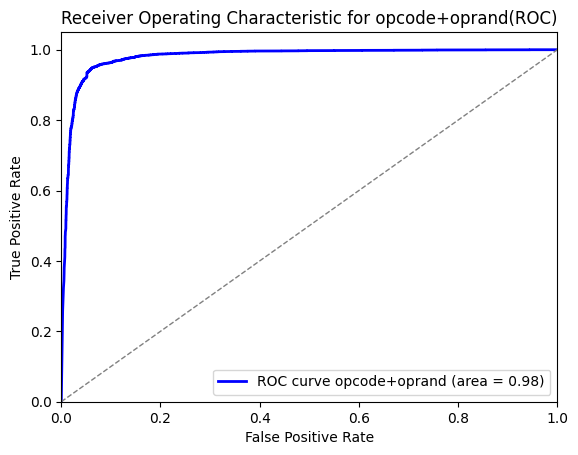

ROC AUC: 0.98


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model
siamese_model = tf.keras.models.load_model("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/siamese_model.h5")


y_pred = siamese_model.predict([X1_test, X2_test])

# Compute ROC curve and AUC using continuous scores
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve opcode+oprand (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for opcode+oprand(ROC)')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC score
print(f'ROC AUC: {roc_auc:.2f}')


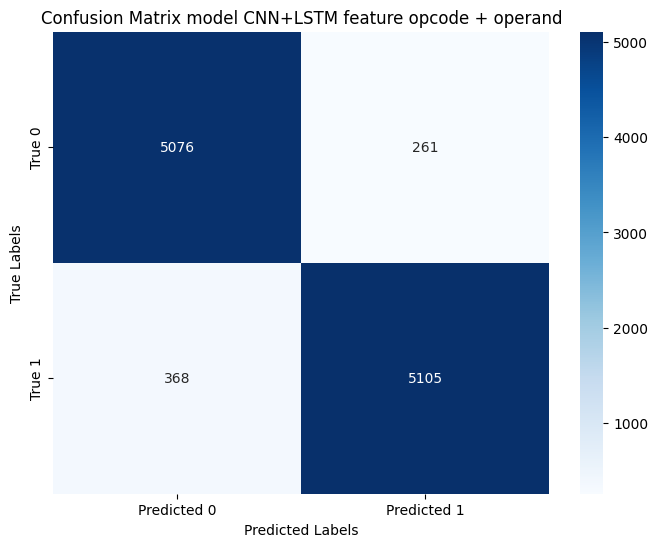

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Compute the confusion matrix
y_pred_bin = np.round(y_pred).astype(int)
cm = confusion_matrix(y_pred_bin , y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix model CNN+LSTM feature opcode + operand')
plt.show()


# kết luận cho đặc tính opcode + mnemonic

Đối tượng nghiên cứu: The same architecure, Cross-optimization, Cross-compiler

Với dataset gồm cùng kiến trúc x86 hoặc x64 và khác optimization hoặc khác complier với tổng số mẫu là 27 000 hàm có điều kiện như trên là giống nhau và 27000 hàm là khác nhau. Mô hình BinDeep của tác giả cho ra kết quả khá cao với Accuracy là 0.94 trên tập test.

Tỉ lệ dương tính sai và âm tính sai thấp, điều nay cho thấy hiệu quả của mô hình binDeep trong việc xác định độ tương đồng của các hàm trong mã nhị phân của các file nhị phân có cùng kiến trúc và khác cross-complier và cross-optimization.




# model CNN+LSTM  features Opcode sequence

In [ ]:

directory = '/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data'


all_files = os.listdir(directory)


csv_files = [file for file in all_files if file.endswith('.csv')]


dfs = []

# Loop through the CSV files and read them into DataFrames
for file in csv_files:
    file_path = os.path.join(directory, file)
    print(file_path)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df)

/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_37828-43232.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_27020-32424.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_21616-27020.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_32424-37828.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_16212-21616.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_10808-16212.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_43232-48636.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_5404-10808.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_0-5404.csv
/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/extract_data/data_48636-54046.csv
                                               function1  \
0      push TypeOne,push TypeOne,push TypeOne,mov Typ...

In [ ]:
df = combined_df.copy()

In [ ]:
def pad_or_truncate_instructions_opcode(instruction_sequence, max_length=1000):
    instruction_sequence = [item.split()[0] for item in instruction_sequence]
    if len(instruction_sequence) < max_length:
        # Pad with "nop" instructions
        instruction_sequence += ["nop"] * (max_length - len(instruction_sequence))
    elif len(instruction_sequence) > max_length:
        # Truncate to keep only the first max_length instructions
        instruction_sequence = instruction_sequence[:max_length]
    return ' '.join(instruction_sequence)

# Split each cell by commas and apply padding/truncating
df['function1'] = df['function1'].apply(lambda x: pad_or_truncate_instructions_opcode(x.split(',')))
df['function2'] = df['function2'].apply(lambda x: pad_or_truncate_instructions_opcode(x.split(',')))


In [ ]:
df.head()

,function1,function2,label
0,push push push mov mov call add mov mov lea cm...,sub mov mov mov mov xor cmp jz mov mov mov mov...,0
1,push mov push push push sub call pop add mov m...,push mov push push push sub mov mov mov mov mo...,0
2,push mov push sub call add mov mov test jz mov...,push push push push sub call add mov mov push ...,0
3,push push sub call test jz mov call test mov j...,push push sub call mov mov call lea call mov m...,0
4,push push push push push sub mov mov mov xor c...,sub push push push push call add push push pus...,0


In [ ]:
# Combine both function1 and function2 into a single list of instructions
instructions_opcode = df['function1'].tolist() + df['function2'].tolist()

# Tokenize instructions
tokenized_instructions_opcode = [instr.split() for instr in instructions_opcode]

# Train Word2Vec model
word2vec_model_opcode = Word2Vec(sentences=tokenized_instructions_opcode, vector_size=300, window=5, min_count=1, sg=1)

In [ ]:
model_path_opcode = "/content/drive/MyDrive/HK2_2023-2024/NT522/ProcessData/word2vecmodel/word2vec_model_opcode.model"
# word2vec_model_opcode.save(model_path_opcode)

In [ ]:
word2vec_model_opcode= Word2Vec.load(model_path_opcode)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize the instructions
df['function1'] = df['function1'].apply(lambda x: x.split())
df['function2'] = df['function2'].apply(lambda x: x.split())



# Create a dictionary mapping from words to their index in the Word2Vec vocabulary
word_index = {word: idx for idx, word in enumerate(word2vec_model_opcode.wv.index_to_key)}

# Function to convert instructions to their corresponding indices
def instructions_to_indices(instructions, word_index):
    return [word_index[word] if word in word_index else 0 for word in instructions]

# Convert instructions to indices
df['function1_indices'] = df['function1'].apply(lambda x: instructions_to_indices(x, word_index))
df['function2_indices'] = df['function2'].apply(lambda x: instructions_to_indices(x, word_index))

# Pad or truncate the instruction sequences
max_length = 1000
df['function1_indices'] = pad_sequences(df['function1_indices'], maxlen=max_length, padding='post', truncating='post').tolist()
df['function2_indices'] = pad_sequences(df['function2_indices'], maxlen=max_length, padding='post', truncating='post').tolist()

# Prepare the input data
X1 = np.array(df['function1_indices'].tolist())
X2 = np.array(df['function2_indices'].tolist())
y = np.array(df['label'].values)

# Split the data into training and testing sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [ ]:


class SiameseNetwork:
    def __init__(self, input_shape, word2vec_model):
        self.input_shape = input_shape
        self.word2vec_model = word2vec_model

    def build_network_branch(self):
        input_layer = Input(shape=self.input_shape)

        # Embedding layer
        embedding_layer = Embedding(input_dim=len(self.word2vec_model.wv),  # Vocabulary size from Word2Vec
                                    output_dim=300,  # Output dimension as specified
                                    weights=[self.word2vec_model.wv.vectors],  # Pre-trained weights from Word2Vec
                                    input_length=self.input_shape[0],  # Input sequence length
                                    trainable=False)(input_layer)

        # LSTM layer
        lstm_layer = LSTM(units=20, return_sequences=True)(embedding_layer)

        # CNN layer
        cnn_layer = Conv1D(filters=300, kernel_size=5, strides=1, activation='relu')(lstm_layer)

        # Max pooling layer
        max_pooling_layer = MaxPooling1D(pool_size=2, strides=2)(cnn_layer)

        # Flatten the output
        flatten_layer = Flatten()(max_pooling_layer)

        # Dense layer
        dense_layer = Dense(units=300, activation='relu')(flatten_layer)

        return Model(inputs=input_layer, outputs=dense_layer)

    def build_siamese_network(self):
        # Build the two branches of the Siamese network
        siamese_branch = self.build_network_branch()

        # Input layers for the two functions
        input_1 = Input(shape=self.input_shape)
        input_2 = Input(shape=self.input_shape)

        # Generate the embeddings for the two functions
        processed_1 = siamese_branch(input_1)
        processed_2 = siamese_branch(input_2)

        # Calculate the absolute difference between the two embeddings
        L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([processed_1, processed_2])

        # Final Dense layer for classification
        output_layer = Dense(units=1, activation='sigmoid')(L1_distance)

        # Create the Siamese network model
        siamese_model = Model(inputs=[input_1, input_2], outputs=output_layer)
        return siamese_model



# Define input shape
input_shape = (1000,)

# Instantiate the SiameseNetwork class
siamese_network = SiameseNetwork(input_shape=input_shape, word2vec_model=word2vec_model_opcode)

# Build the Siamese network
siamese_model_opcode = siamese_network.build_siamese_network()

# Compile the model
siamese_model_opcode.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
siamese_model_opcode.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 model_2 (Functional)        (None, 300)                  4495578   ['input_5[0][0]',             
                                                          0          'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 300)                  0         ['model_2[0][0]',       

In [ ]:
siamese_model_opcode.fit([X1_train, X2_train], y_train, epochs=10, batch_size=32, validation_data=([X1_test, X2_test], y_test))
siamese_model_opcode.save_weights("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/opcode_siamese_model_weights.h5")
siamese_model_opcode.save("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/opcode_siamese_model.h5")

Epoch 1/10
1352/1352 [==============================] - 903s 664ms/step - loss: 0.3513 - accuracy: 0.8650 - val_loss: 0.2712 - val_accuracy: 0.9070
Epoch 2/10
1352/1352 [==============================] - 831s 615ms/step - loss: 0.1995 - accuracy: 0.9322 - val_loss: 0.2068 - val_accuracy: 0.9315
Epoch 3/10
1352/1352 [==============================] - 818s 605ms/step - loss: 0.1229 - accuracy: 0.9602 - val_loss: 0.2139 - val_accuracy: 0.9383
Epoch 4/10
1352/1352 [==============================] - 799s 591ms/step - loss: 0.0846 - accuracy: 0.9758 - val_loss: 0.2611 - val_accuracy: 0.9393
Epoch 5/10
1352/1352 [==============================] - 789s 584ms/step - loss: 0.0603 - accuracy: 0.9835 - val_loss: 0.2547 - val_accuracy: 0.9412
Epoch 6/10
1352/1352 [==============================] - 771s 570ms/step - loss: 0.0460 - accuracy: 0.9895 - val_loss: 0.3208 - val_accuracy: 0.9331
Epoch 7/10
1352/1352 [==============================] - 783s 579ms/step - loss: 0.0342 - accuracy: 0.9918 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:


siamese_model_opcode = tf.keras.models.load_model("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/opcode_siamese_model.h5")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tabulate import tabulate

def evaluate_siamese_model(model, X1_test, X2_test, y_test):
    """
    Evaluate the Siamese model and print various performance metrics.

    :param model: Trained Siamese model
    :param X1_test: Test features from the first input
    :param X2_test: Test features from the second input
    :param y_test: True labels for the test set
    """
    # Get predictions
    y_pred = model.predict([X1_test, X2_test])

    # Convert predictions to binary labels based on a threshold
    threshold = 0.5
    y_pred_binary = (y_pred > threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    accuracy = accuracy_score(y_test, y_pred_binary)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Calculate FPR and FNR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Create table
    table_data = [
        ["Metric", "Score"],
        ["Precision", precision],
        ["Recall", recall],
        ["F1 Score", f1],
        ["Accuracy", accuracy],
        ["False Positive Rate (FPR)", fpr],
        ["False Negative Rate (FNR)", fnr]
    ]

    # Print table
    print(tabulate(table_data, headers="firstrow", tablefmt='grid'))

# Assuming you have a trained model and test data available
evaluate_siamese_model(siamese_model_opcode, X1_test, X2_test, y_test)


338/338 [==============================] - 49s 144ms/step
+---------------------------+-----------+
| Metric                    |     Score |
+===========================+===========+
| Precision                 | 0.955071  |
+---------------------------+-----------+
| Recall                    | 0.923034  |
+---------------------------+-----------+
| F1 Score                  | 0.938779  |
+---------------------------+-----------+
| Accuracy                  | 0.940241  |
+---------------------------+-----------+
| False Positive Rate (FPR) | 0.0427994 |
+---------------------------+-----------+
| False Negative Rate (FNR) | 0.0769661 |
+---------------------------+-----------+


338/338 [==============================] - 68s 200ms/step


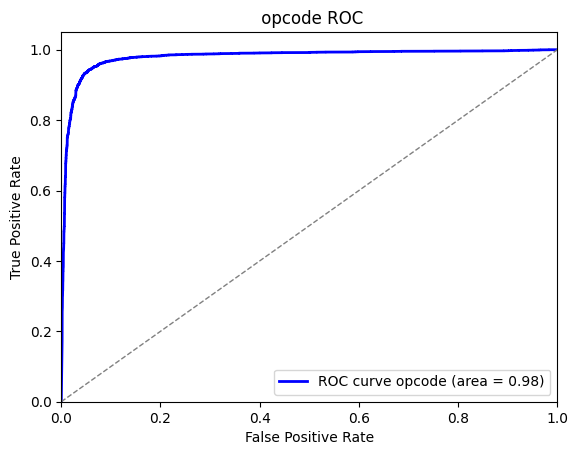

ROC AUC: 0.98


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model



y_pred = siamese_model_opcode.predict([X1_test, X2_test])

# Compute ROC curve and AUC using continuous scores
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve opcode (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' opcode ROC')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC score
print(f'ROC AUC: {roc_auc:.2f}')


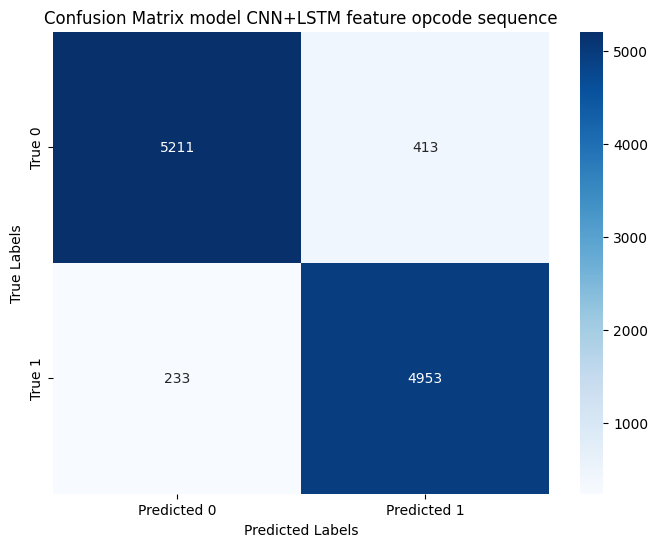

In [ ]:
# Compute the confusion matrix
y_pred_bin = np.round(y_pred).astype(int)
cm = confusion_matrix(y_pred_bin , y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix model CNN+LSTM feature opcode sequence')
plt.show()


# demo mô hình học máy
Kịch bản: demo trên trang web streamlit.io

Dạng đầu vào là 2 mã hợp ngữ của hai hàm dưới dạng list python  ví dụ
Hàm ```["test    rdi, rdi",
        "jz      loc_28D18",
        "push    rbp",
        "mov     eax, 1",
        "mov     rbp, rdi", ]````

ứng dụng sẽ tiền xủ lý 2 hàm này và cho vào mô hình để dự đoạn xem 2 đoạn code có tương đồng hay không.

Đối tượng là 2 binary có cùng kiến trúc x86, x64 và và khác optimizer, hay khác complier


### demo cho đặc tính opcode+mnemonic

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

In [ ]:



with open("/content/x64-gcc-9-O1_curl.json", 'r') as json_file:
    data1 = json.load(json_file)
    # print(data1

with open("/content/x86-clang-9-O3_curl.json", 'r') as json_file:
    data2 = json.load(json_file)
    # print(data2


In [ ]:
for d2, d1 in zip(data1["libcurl_generate_slist"][:20], data2["libcurl_generate_slist"][:20]):
    print(f"{d2:<20}                                      {d1:<20}")

push    r14                                               push    ebp         
push    r13                                               push    ebx         
push    r12                                               push    edi         
push    rbp                                               push    esi         
push    rbx                                               sub     esp, 0Ch    
mov     rbp, rdi                                          mov     esi, edx    
mov     r12, rsi                                          mov     edi, ecx    
mov     eax, cs:easysrc_slist_count                                      mov     eax, ds:easysrc_slist_count
lea     edx, [rax+1]                                      inc     eax         
mov     cs:easysrc_slist_count, edx                                      mov     ds:easysrc_slist_count, eax
mov     [rsi], edx                                        mov     [edx], eax  
lea     rsi, aStructCurl_sli; "struct curl_slist *slist%d;"            

In [ ]:
function1 = list(normalize_function(data2["libcurl_generate_slist"]))
function2 = list(normalize_function(data1["libcurl_generate_slist"]))

In [ ]:
for f2, f1 in zip(function1[:20], function2[:20]):
    print(f"{f2:<20}                             {f1:<20}")

push TypeOne                                     push TypeOne        
push TypeOne                                     push TypeOne        
push TypeOne                                     push TypeOne        
push TypeOne                                     push TypeOne        
sub TypeOne TypeFive                             push TypeOne        
mov TypeOne TypeOne                              mov TypeOne TypeOne 
mov TypeOne TypeOne                              mov TypeOne TypeOne 
mov TypeOne TypeEight                             mov TypeOne TypeEight
inc TypeOne                                      lea TypeOne TypeThree
mov TypeEight TypeOne                             mov TypeEight TypeOne
mov TypeTwo TypeOne                              mov TypeTwo TypeOne 
sub TypeOne TypeFive                             lea TypeOne TypeEight
push TypeOne                                     lea TypeOne TypeEight
push TypeEight TypeEight                             mov TypeOne TypeFive
push Type

In [ ]:
# Create a dictionary mapping from words to their index in the Word2Vec vocabulary
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key)}
# Function to convert instructions to their corresponding indices
def instructions_to_indices(instructions, word_index):
    return [word_index[word] if word in word_index else 0 for word in instructions]



In [ ]:
def pad_or_truncate_instructions(instruction_sequence, max_length=1000):
    if len(instruction_sequence) < max_length:
        # Pad with "nop" instructions
        instruction_sequence += ["nop"] * (max_length - len(instruction_sequence))
    elif len(instruction_sequence) > max_length:
        # Truncate to keep only the first max_length instructions
        instruction_sequence = instruction_sequence[:max_length]
    return ' '.join(instruction_sequence)

In [ ]:
x1 = pad_or_truncate_instructions(function1)
x2 = pad_or_truncate_instructions(function2)


In [ ]:
x1 = instructions_to_indices(x1.split(), word_index)
x2 = instructions_to_indices(x2.split(), word_index)

In [ ]:
x1 = pad_sequences([x1], maxlen=1000, padding='post', truncating='post').tolist()
x2 = pad_sequences([x2], maxlen=1000, padding='post', truncating='post').tolist()

In [ ]:
x1 = np.array(x1)
x2 = np.array(x2)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/siamese_model.h5")

In [ ]:
y_pred = model.predict([x1, x2])

1/1 [==============================] - 0s 119ms/step


In [ ]:
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

In [ ]:
if y_pred_binary[0][0] == 1:
    print("Hàm 1 và hàm 2 tương đồng")
else:
    print("Hàm 1 và hàm 2 không tương đồng")

Hàm 1 và hàm 2 tương đồng


# demo cho đặc tính chuỗi opcode

In [ ]:
def pad_or_truncate_instructions_opcode(instruction_sequence, max_length=1000):
    instruction_sequence = [item.split()[0] for item in instruction_sequence]
    if len(instruction_sequence) < max_length:
        # Pad with "nop" instructions
        instruction_sequence += ["nop"] * (max_length - len(instruction_sequence))
    elif len(instruction_sequence) > max_length:
        # Truncate to keep only the first max_length instructions
        instruction_sequence = instruction_sequence[:max_length]
    return ' '.join(instruction_sequence)

In [ ]:
function1 = list(normalize_function(data2["libcurl_generate_slist"]))
function2 = list(normalize_function(data1["libcurl_generate_slist"]))

In [ ]:
x1 = pad_or_truncate_instructions_opcode(function1)
x2 = pad_or_truncate_instructions_opcode(function2)

In [ ]:
# Create a dictionary mapping from words to their index in the Word2Vec vocabulary
word_index = {word: idx for idx, word in enumerate(word2vec_model_opcode.wv.index_to_key)}

# Function to convert instructions to their corresponding indices
def instructions_to_indices(instructions, word_index):
    return [word_index[word] if word in word_index else 0 for word in instructions]

In [ ]:
x1 = instructions_to_indices(x1.split(), word_index)
x2 = instructions_to_indices(x2.split(), word_index)

In [ ]:
x1 = pad_sequences([x1], maxlen=1000, padding='post', truncating='post').tolist()
x2 = pad_sequences([x2], maxlen=1000, padding='post', truncating='post').tolist()

In [ ]:
x1 = np.array(x1)
x2 = np.array(x2)

In [ ]:
siamese_model_opcode = tf.keras.models.load_model("/content/drive/MyDrive/HK2_2023-2024/NT522/Result/models/siamese/opcode_siamese_model.h5")

In [ ]:
y_pred = siamese_model_opcode.predict([x1, x2])

1/1 [==============================] - 1s 939ms/step


In [ ]:
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

In [ ]:
if y_pred_binary[0][0] == 1:
    print("Hàm 1 và hàm 2 tương đồng")
else:
    print("Hàm 1 và hàm 2 không tương đồng")

Hàm 1 và hàm 2 tương đồng
